In [133]:
import torch_geometric
from torch_geometric.datasets import MoleculeNet
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn.conv import GATv2Conv, GATConv, TransformerConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import BondType, HybridizationType
import os
import matplotlib.pyplot as plt

In [134]:
dataset = MoleculeNet(name="lipo", root="MoleculeNet")

In [135]:
class GCN_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32, dataset=dataset):
        super().__init__()
        self.layer = layer
        self.dataset = dataset
        self.dim = dim
        self.conv1 = GCNConv(self.dataset.num_node_features, self.dim, improved=True)
        self.convn = GCNConv(self.dim, self.dim, improved=True)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = x.to(torch.float)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

In [136]:
#データの分割(total: 130831)
num_train, num_val = int(len(dataset)*0.6), int(len(dataset)*0.2)
num_test = len(dataset) - (num_train + num_val)
batch_size = 32

# 乱数の固定
device = torch.device("cpu")
seed = 0
pyg.seed_everything(seed=seed)
train_set, valid_set, test_set = random_split(dataset, [num_train, num_val, num_test])

#Dataloaderの生成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=pyg.seed_everything(seed))
valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))

layer = 3
dim = 32
model = GCN_N(layer=layer,dim=dim)
# 損失関数
criterion = F.mse_loss
# Optimizerの初期化
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)

(array([ 53., 112., 162., 327., 447., 688., 762., 911., 528., 210.]),
 array([-1.5, -0.9, -0.3,  0.3,  0.9,  1.5,  2.1,  2.7,  3.3,  3.9,  4.5]),
 <BarContainer object of 10 artists>)

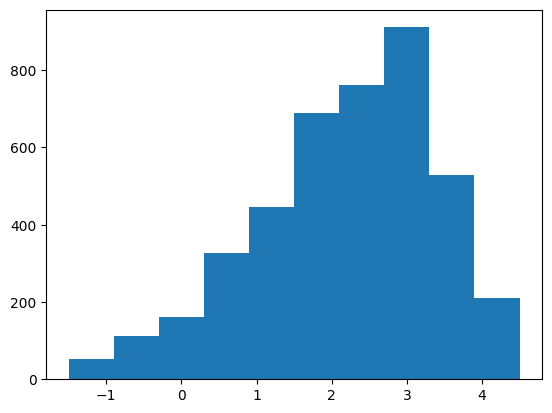

In [147]:
y = [i.item() for i in dataset.y]
plt.hist(y)


In [139]:
from math import sqrt
from sklearn.metrics import r2_score

for epoch in range(100):
    # train
    model.train()
    train_loss = 0
    total_graphs = 0
    for batch in train_loader:
        batch = batch.to("cpu")
        optimizer.zero_grad()
        prediction = model(batch)
        #loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
        loss = criterion(prediction, batch.y)
        loss.backward()
        train_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_loss /=  len(train_loader) #損失の平均(batchあたり) #平均を取ってからルート
    train_loss = sqrt(train_loss)
    

    # validation
    model.eval()
    valid_loss = 0
    total_graphs = 0
    with torch.inference_mode(): # 自動微分無効。torch.no_grad()よりさらに高速化
        for batch in valid_loader:
            prediction = model(batch)
            #loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
            loss = criterion(prediction, batch.y)
            valid_loss += loss.item()
            total_graphs += batch.num_graphs
    valid_loss /= len(valid_loader)
    valid_loss = sqrt(valid_loss)

    print(f"Epoch {epoch+1} | train_loss:{train_loss}, valid_loss:{valid_loss}")
    #loss_three_50.append({"Epoch":epoch + 1 , "train_loss":train_loss, "valid_loss":valid_loss})

Epoch 1 | train_loss:0.984069940973217, valid_loss:1.0330747201280532
Epoch 2 | train_loss:0.9896199545966121, valid_loss:1.0141647905534206
Epoch 3 | train_loss:0.98577363008561, valid_loss:1.013377153393055
Epoch 4 | train_loss:0.984529713978718, valid_loss:1.0261124555821868
Epoch 5 | train_loss:0.979943129318999, valid_loss:1.0334977358436948
Epoch 6 | train_loss:0.9861215325587892, valid_loss:1.018725092045331
Epoch 7 | train_loss:0.984322895083636, valid_loss:1.0375830428147808
Epoch 8 | train_loss:0.9693014976607417, valid_loss:1.0063442056249752
Epoch 9 | train_loss:0.9890587902386656, valid_loss:1.0196995266765754
Epoch 10 | train_loss:0.9818051062417332, valid_loss:1.0010953099113646
Epoch 11 | train_loss:0.9728077781171853, valid_loss:1.0268936159546376
Epoch 12 | train_loss:1.0668915900738016, valid_loss:1.025257452065658
Epoch 13 | train_loss:0.9766882038577094, valid_loss:1.0383499940481553
Epoch 14 | train_loss:0.9742696371267079, valid_loss:1.0186766161380045
Epoch 15 |